In [150]:
import pandas as pd
import numpy as np

In [151]:
prices_data = pd.read_csv("futures-pnls.csv")

In [152]:
prices_data.index = pd.to_datetime(prices_data["Date"])

In [153]:
initial_price_columns = [col for col in prices_data.columns if col != 'Date']
window_size = 60*72
inv_vol_cols = []

for column_name in initial_price_columns:
    prices_data[f'Log_Ret_{column_name}'] = np.log(prices_data[column_name] / prices_data[column_name].shift(1)).fillna(0)
    prices_data[f'Volatility_{column_name}'] = prices_data[f'Log_Ret_{column_name}'].rolling(window=window_size).std() * np.sqrt(window_size)
    prices_data[f'Inverse_Volatility_{column_name}'] = 1/prices_data[f'Volatility_{column_name}']
    inv_vol_cols.append(f'Inverse_Volatility_{column_name}')

In [154]:
start_of_day_data = prices_data.resample('D').first()

In [155]:
start_of_day_data.dropna(subset=['Date'] + inv_vol_cols, inplace=True)

In [159]:
log_returns_volatility_targeting = []
log_returns_buy_hold_baseline = []
for i in range(len(start_of_day_data) - 1):
    current_row = start_of_day_data.iloc[i]
    next_row = start_of_day_data.iloc[i + 1]
    correct_cols = []
    volatility_cols = []
    for col in initial_price_columns:
        if np.isnan(current_row[col]) == False and np.isnan(next_row[col]) == False and np.isinf(current_row[f'Inverse_Volatility_{col}']) == False:
            correct_cols.append(col)
            volatility_cols.append(f'Inverse_Volatility_{col}')
    weights = (current_row[volatility_cols]/current_row[volatility_cols].sum()).values

    log_returns_volatility_targeting.append(np.log(np.average(next_row[correct_cols], weights=weights)) - np.log(np.average(current_row[correct_cols], weights=weights)))
    log_returns_buy_hold_baseline.append(np.log(np.average(next_row[correct_cols])) - np.log(np.average(current_row[correct_cols])))
        

In [160]:
start_of_day_data["log_returns_volatility_targeting"] = log_returns_volatility_targeting + [0]
start_of_day_data["log_returns_buy_hold_baseline"] = log_returns_buy_hold_baseline + [0]

Start date,2011-12-06
End date,2025-03-31
Total months,163
,Backtest
Annual return,-0.009%
Cumulative returns,-0.117%
Annual volatility,1.285%
Sharpe ratio,-0.00
Calmar ratio,-0.00
Stability,0.00
Max drawdown,-7.125%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,7.13,2012-02-28,2020-03-18,NaT,NaN
1,0.68,2011-12-06,2011-12-14,2012-01-23,35
2,0.17,2012-02-07,2012-02-13,2012-02-24,14
3,0.11,2012-01-27,2012-01-30,2012-02-03,6
4,0.00,2012-02-24,2012-02-27,2012-02-28,3


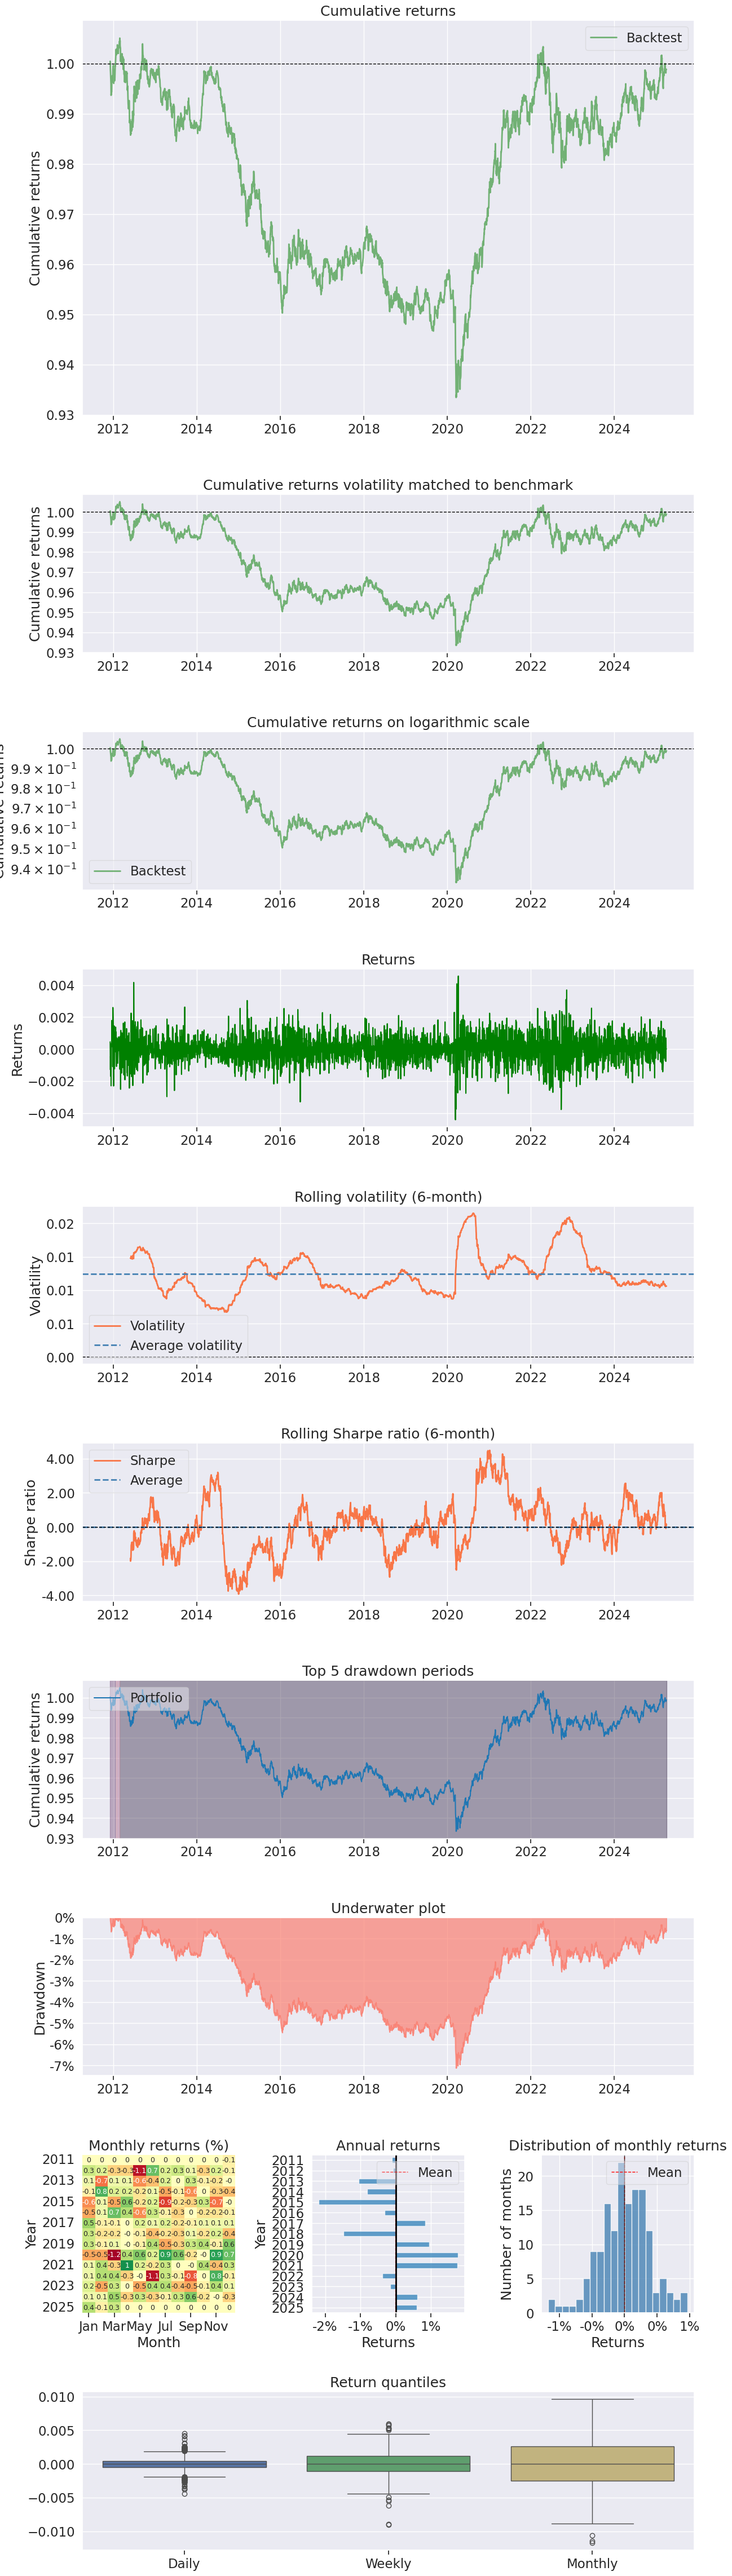

In [162]:
pf.create_returns_tear_sheet(start_of_day_data["log_returns_buy_hold_baseline"])

Start date,2011-12-06
End date,2025-03-31
Total months,163
,Backtest
Annual return,-0.015%
Cumulative returns,-0.205%
Annual volatility,1.11%
Sharpe ratio,-0.01
Calmar ratio,-0.00
Stability,0.00
Max drawdown,-6.17%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,6.17,2012-02-28,2020-03-18,NaT,NaN
1,0.59,2011-12-06,2011-12-14,2012-01-25,37
2,0.09,2012-02-07,2012-02-13,2012-02-16,8
3,0.09,2012-01-27,2012-01-30,2012-02-01,4
4,0.03,2012-02-24,2012-02-27,2012-02-28,3


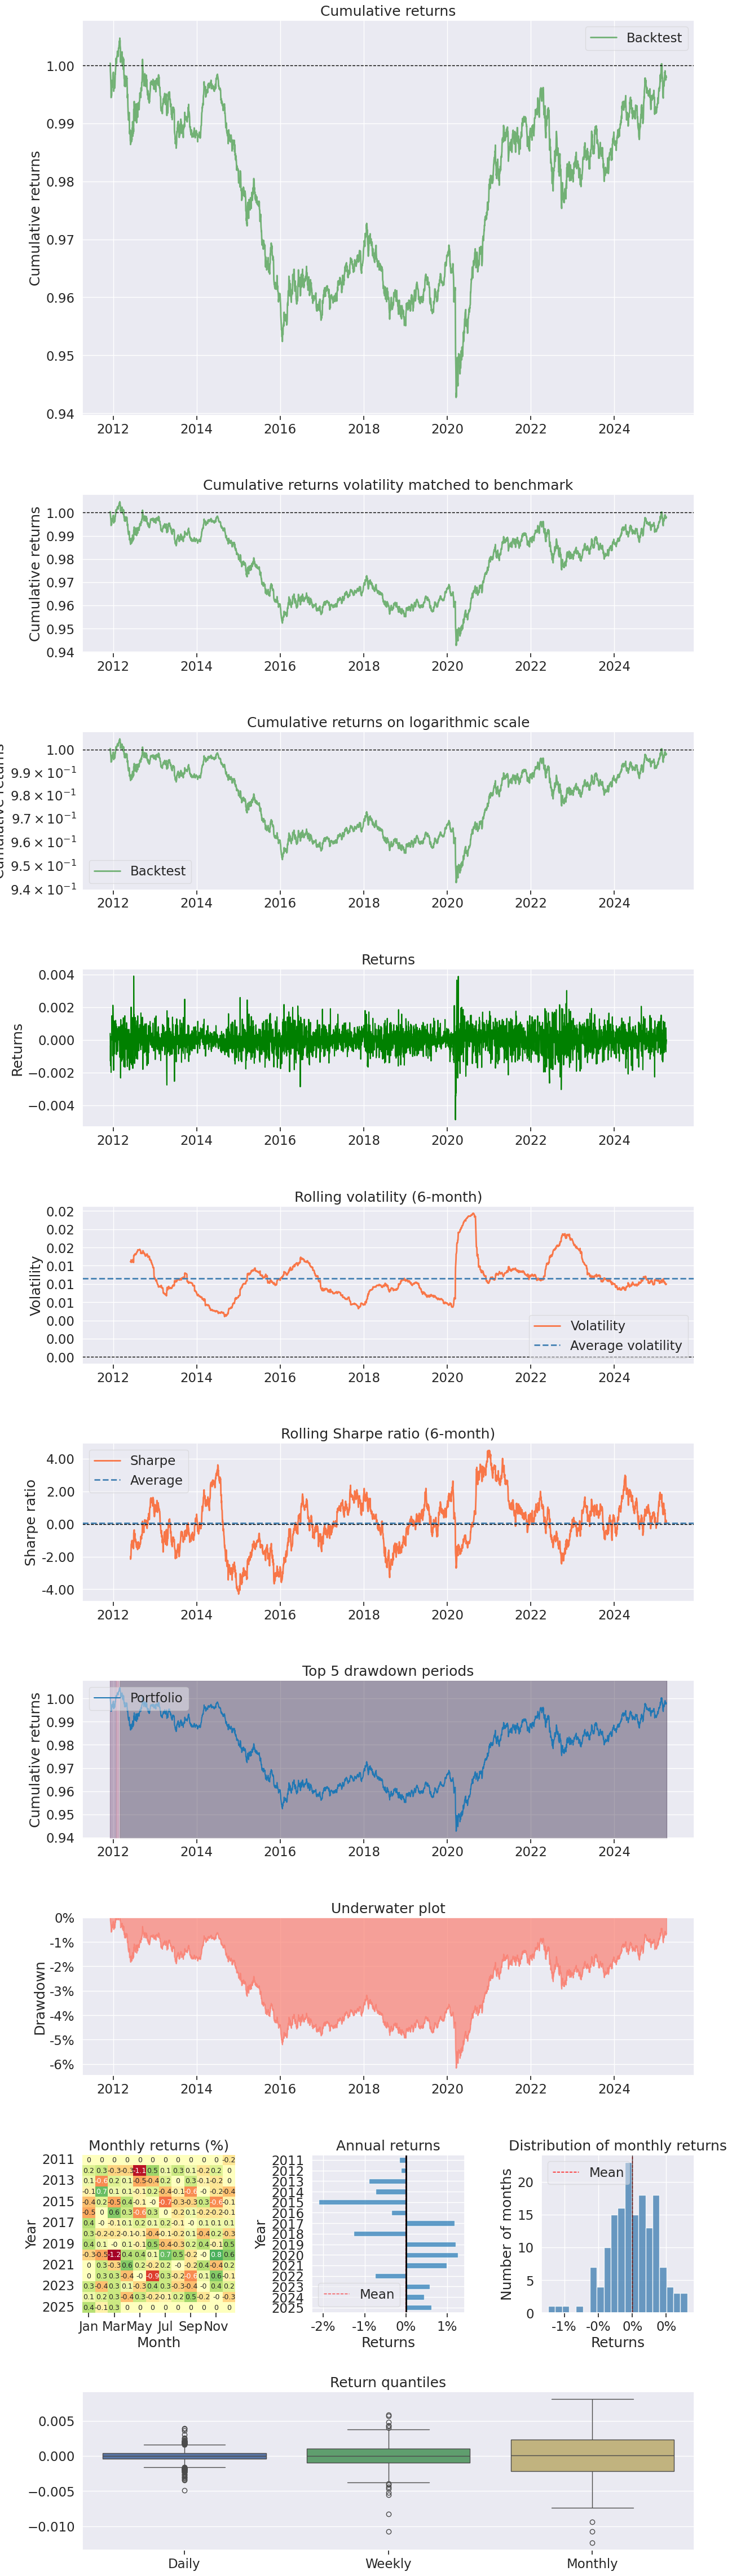

In [161]:
pf.create_returns_tear_sheet(start_of_day_data["log_returns_volatility_targeting"])

Итого оба метода дает отрицательную доходность, но у volatility_targeting ожидаемо меньшая волатильность